# Notes

1. This notebook was entirely built and tested using Google Colab
2. Part 1 Sentiment Analysis uses the data set of 50000 movie reviews from IMDB
3. Part 2 - Sarcasm Detection uses the data sets created based on content from theonion.com and huffingtonpost.com 

Import and download the required libraries

In [303]:
from google.colab import drive, files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # matplotlib.pyplot plots data
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)

import re, random, json
from itertools import islice
from zipfile import ZipFile
from IPython.display import HTML, display

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet'); 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Bidirectional, GlobalMaxPool1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import Constant

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Mount the Google Drive where the data sets will be stored for processing

In [304]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Part 1 - Sentiment Analysis

The purpose of this assignment is to to build a text classification model to
analyze and determine customer sentiments based on their IMDB reviews. 

The IMDB dataset contains 50000 movie reviews labelled by sentiment, which can be "positive" or "negative". The first 20 words of each review and a vocab size of 10000 are used to speed up training

Load the movie review data set into training and test data sets, restricting vocabulary size to 10000

In [305]:
n_vocab = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = n_vocab)

Set the sequence length to 200 and pre-pad the sequences to bring them to same length

Split the cocatenated data set into training and test data sets with a 20% split

Split the training data set into training and vaidation data sets with a 20% split

In [306]:
length=200
X_train = pad_sequences(X_train, maxlen = length, padding = 'pre')
X_test =  pad_sequences(X_test, maxlen = length, padding = 'pre')

X = np.concatenate((X_train, X_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)

random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state , shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = random_state, shuffle = True)

Let's explore the shape of the data set

In [307]:
print("Training dataset")
print(f'Shape: {X_train.shape}')
print(f'Unique words: {len(np.unique(np.hstack(X_train)))}\n')

print("Validation dataset")
print(f'Shape: {X_val.shape}')
print(f'Unique words: {len(np.unique(np.hstack(X_val)))}\n')

print("Test dataset")
print(f'Shape: {X_test.shape}')
print(f'Unique words: {len(np.unique(np.hstack(X_test)))}\n')

Training dataset
Shape: (32000, 200)
Unique words: 9999

Validation dataset
Shape: (8000, 200)
Unique words: 9977

Test dataset
Shape: (10000, 200)
Unique words: 9991



Create a key-value pair for word and word id, also return word index. Let us visualize a few key/value pairs

In [308]:
def decode_review(x, y):
  w2i = imdb.get_word_index()                                
  w2i = {k:(v + 3) for k, v in w2i.items()}
  w2i['<PAD>'] = 0
  w2i['<START>'] = 1
  w2i['<UNK>'] = 2
  i2w = {i: w for w, i in w2i.items()}

  ws = (' '.join(i2w[i] for i in x))
  print(f'Review: {ws}')
  print(f'Actual Sentiment: {y}')
  return w2i, i2w

w2i, i2w = decode_review(X_train[0], y_train[0])

# get first 50 key, value pairs from id to word dictionary
print('\nFirst few key-value pairs are as follows\n', list(islice(i2w.items(), 0, 50)))

Review: brain cells die and once you are officially mentally retarded perhaps then you might enjoy this film br br the only saving grace was the story between <UNK> and stephanie govinda was excellent in the role of the cab driver and so was the brit girl perhaps if they would have created the whole movie on their <UNK> in india and how they eventually fall in love would have made it a much more enjoyable film br br the only reason i gave it a 3 rating is because of <UNK> and his ability as an actor when it comes to comedy br br <UNK> <UNK> and anil kapoor were wasted needlessly plus the scene at <UNK> of the re union was just too much to <UNK> being an international <UNK> in the post 9 11 world anil kapoor would have got himself shot much before he even reached the sky bridge to <UNK> his true love but then again the point of the movie was to defy logic gravity physics and throw an egg on the face of the general audience br br watch it at your own peril at least i know i have been <UN

Build a fully connected NN with the following 

1. Embedding layer containing the input embedding vector that will be passed to the hidden layers

2. Convolution layers, Pooling and Dense Layers to learn the weights using forward and back prop

3. LSTM layer with 75 sequential units

4. Dropout layer that drop weights to prevent overfitting 

5. Output layer that uses a sigmoid function with binary cross entropy, since the output is binary (1 or 0 sentiment)

In [309]:
# Create the network
model = Sequential()
model.add(Embedding(n_vocab, 256, input_length = length))
model.add(Dropout(0.5))
model.add(Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(Conv1D(128, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(75))
model.add(Dense(1, activation = 'sigmoid'))

Compile the model and display the model summary. 

Add callbacks for Early stopping and saving best model based on least validation loss

In [310]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

# Adding callbacks
stop_early = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 0)  
save_best_model = ModelCheckpoint('imdb_best_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 256)          2560000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 200, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 256)          327936    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 128)          163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 64)           41024     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 64)           

Train the model for 5 epochs with a batch size of 64 and the callbacks defined above

In [311]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 5, batch_size = 64, verbose = True, callbacks = [stop_early, save_best_model])

# Evaluate the model
scores = model.evaluate(X_test, y_test, batch_size = 64)
print('\nTest accuracy:',(round(scores[1]*100,2)),'%')

Epoch 1/5
500/500 [==============================] - 27s 49ms/step - loss: 0.5100 - accuracy: 0.6916 - val_loss: 0.2582 - val_accuracy: 0.8934

Epoch 00001: val_loss improved from inf to 0.25820, saving model to imdb_best_model.h5
Epoch 2/5
500/500 [==============================] - 23s 47ms/step - loss: 0.1933 - accuracy: 0.9277 - val_loss: 0.2595 - val_accuracy: 0.8961

Epoch 00002: val_loss did not improve from 0.25820
Epoch 00002: early stopping
157/157 [==============================] - 2s 9ms/step - loss: 0.2560 - accuracy: 0.8956

Test accuracy: 89.56 %


We can observe that the model settles at around 90% validation accuracy without overfitting on the data set. We consider this to be good enough to start making predictions

Make predictions on the test data set and print the classification report

In [312]:
y_pred = model.predict_classes(X_test)
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4602
           1       0.93      0.87      0.90      5398

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



We also observe that the precision and recall metrics are around 90%, indicating a healthy performing model

In [313]:
# sample_x_test = X_test[np.random.randint(X_test.shape[0])]

# for layer in model.layers:
#     model_layer = Model(inputs = model.input, outputs = model.get_layer(layer.name).output)
#     output = model_layer.predict(sample_x_test.reshape(1,-1))
#     print('\n','--'*20, layer.name, 'layer', '--'*20, '\n')
#     print(output)

Take 5 random entries from the data set and display the predicted/actual sentiments for the reviews

In [314]:
for i in range(5):
  rand = np.random.randint(X_test.shape[0])
  decode_review(X_test[rand], y_test[rand])
  print(f'Predicted sentiment: {y_pred[rand][0]}\n\n')

Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> i've been wanting to see this movie for a very long time i eventually just bought it on e bay since it's so hard to find state side but the wait was somewhat worth it br br i can't say the movie was great and i can't say that the movie was hilarious but it was good and it has some pretty funny points that aside the shots in this movie are just beautiful and the entire cast especially brenda <UNK> someone i hadn't seen before sadly were excellent br br in the end this is a feel good romantic comedy and i recommend checking it out unless you've just had 

We observe that the predicted and actual sentiments are the same for most of the randomly chosen entries.

Conclusion

* The data set was loaded and split into train/test data sets
* Sample data was visualized and data pre-processing such as padding was performed
* A sequential model using LSTM Layer was constructed and used for training the data set
* It is observed that model accuracy and precision, recall values are ~90%
* Random reviews were chosen from the test data set and the sentiment was predicted for them. This is compared with the actual sentiment for each review

# Part 2 - Sarcasm Detection

The objective of this part of the assignment is to build a model to detect if a given sentence is sarcastic. The project uses a sequential NLP classifier that takes in the sentences as input and uses Bidirectional LSTMs to determine the sarcastic index (1, if sarcastic or 0, if not sarcastic)

The data is collected from websites theonion.com and huffingtonpost.com, where content is professionally authored in a formal manner. Also these are reliable sites for genuinely sarcastic content

Read the dataset and print the first few samples

In [315]:
data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Assignments/Sequential NLP/Sarcasm_Headlines_Dataset.json', lines = True)
print(f'There are {data.shape[0]} rows and {data.shape[1]} columns in the data set')
display(data.head())

There are 26709 rows and 3 columns in the data set


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Each row consists of the following 
 - A sequence number
 - Link to the article
 - Headline
 - Sarcastic (1) or Not (0)

Let us perform exploratory data analysis on the data set

In [316]:
n_scs =  data[data.is_sarcastic == 1].shape[0]
p_scs =  round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)
print('There are',n_scs,'rows labelled Sarcastic [',p_scs,'%]')

n_nscs = data[data.is_sarcastic == 0].shape[0]
p_nscs = round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)
print('There are',n_nscs,'rows labelled Isn\'t Sarcastic [',p_nscs,'%]')

There are 11724 rows labelled Sarcastic [ 44.0 %]
There are 14985 rows labelled Isn't Sarcastic [ 56.0 %]


Distributon of Sarcastic vs Non-Sarcastic labelled data

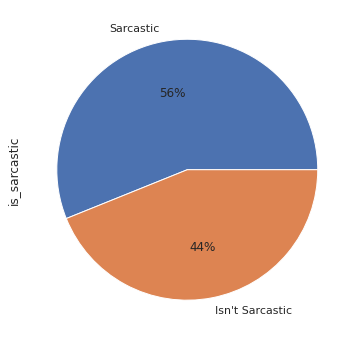

In [317]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Isn\'t Sarcastic'], figsize = (10, 6))

In [318]:
hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['The Huffington Post', 'The Onion'], index = ['Sarcastic', 'Not Sarcastic']))

,The Huffington Post,The Onion
Sarcastic,0,11724
Not Sarcastic,14985,1


It is observed that almost all of "The Onion"'s articles are labelled Sarcastic while none of the "The Huffington Post"'s articles are labelled Sarcastic

Let us display 5 random headlines from the data set and their corresponding Sarcasm label

In [319]:
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel (is_sarcastic): {label}\n') for head, label in zip(headlines, labels)]

Headline: the alabama redemption – perhaps not so surprising
label (is_sarcastic): 0

Headline: man always gets little rush out of telling people john lennon beat wife
label (is_sarcastic): 1

Headline: new desktop folder created for sad little creative project
label (is_sarcastic): 1

Headline: report:  one in five americans currently holding for the next available representative
label (is_sarcastic): 1

Headline: groups working to make the world wide web live up to its name
label (is_sarcastic): 0



Let us check random headlines and labels where the length of headline is greater than 100 characters


In [320]:
indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel (is_sarcastic): {label}\n') for head, label in zip(headlines, labels)]

Headline: don't trust your gut on hillary: why the visceral suspicion of her is predictable – and untrustworthy
label (is_sarcastic): 0

Headline: 'i'll have to obstruct one last thing,' whispers jared kushner before wrapping gloved hands around mueller's neck
label (is_sarcastic): 1

Headline: denny's market researcher emerges from focus group shaken after finding out what americans really want for breakfast
label (is_sarcastic): 1

Headline: report: supplying police with high-powered military weapons to sharply reduce costs of shooting suspects multiple times
label (is_sarcastic): 1

Headline: 'insane' as today's u.s.-russia situation may be, trump and putin don't matter to fx's 'the americans'
label (is_sarcastic): 0



Visualize the Label distribution when headline length is greater than 100

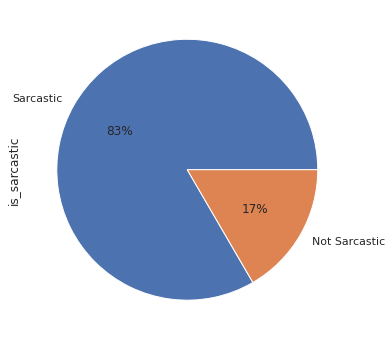

In [321]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Not Sarcastic'], figsize = (10, 6))

It is observed that 83% of the headlines that are above 100 characters in length are labelled 'Sarcastic'

Let us retain only the required columns and drop the others

In [322]:
data.drop('article_link', axis = 1, inplace = True)

We will define a utility function that takes a sentence and cleans it up by  removing apostrophes and retaining the meaning. For e.g. 

*wouldn't is changed to would not*

Also listed is the mapping for words with and without apostrophes 

In [323]:
def replace_words(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in apostrophe_map.keys():
            cleaned_headlines.append(apostrophe_map[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

In [324]:
apostrophe_map =  {"ain't": "am not", "aren't": "are not", "can't": "cannot", 
                  "can't've": "cannot have", "'cause": "because", 
                  "could've": "could have", "couldn't": "could not", 
                  "couldn't've": "could not have", "didn't": "did not", 
                  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                  "hadn't've": "had not have", "hasn't": "has not", 
                  "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
                  "he'll": "he will", "he'll've": "he will have", 
                  "he's": "he is", "how'd": "how did", 
                  "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                  "I'll've": "I will have", "I'm": "I am", "I've": "I have", 
                  "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                  "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
                  "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                  "might've": "might have", "mightn't": "might not", 
                  "mightn't've": "might not have", "must've": "must have", 
                  "mustn't": "must not", "mustn't've": "must not have", 
                  "needn't": "need not", "needn't've": "need not have",
                  "o'clock": "of the clock", "oughtn't": "ought not", 
                  "oughtn't've": "ought not have", "shan't": "shall not", 
                  "sha'n't": "shall not", "shan't've": "shall not have", 
                  "she'd": "she would", "she'd've": "she would have", 
                  "she'll": "she will", "she'll've": "she will have",
                  "she's": "she is", "should've": "should have", 
                  "shouldn't": "should not", "shouldn't've": "should not have", 
                  "so've": "so have", "so's": "so is", 
                  "that'd": "that had", "that'd've": "that would have", 
                  "that's": "that that is", "there'd": "there would", 
                  "there'd've": "there would have", "there's": "there is", 
                  "they'd": "they would", "they'd've": "they would have", 
                  "they'll": "they will", "they'll've": "they will have", 
                  "they're": "they are", "they've": "they have", 
                  "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                  "we'd've": "we would have", "we'll": "we will", 
                  "we'll've": "we will have", "we're": "we are", 
                  "we've": "we have", "weren't": "were not", 
                  "what'll": "what will", "what'll've": "what will have", 
                  "what're": "what are", "what's": "what is", 
                  "what've": "what have", "when's": "when is", 
                  "when've": "when have", "where'd": "where did", 
                  "where's": "where is", "where've": "where have", 
                  "who'll": "who will", "who'll've": "who will have", 
                  "who's": "who is", "who've": "who have", 
                  "why's": "why is", "why've": "why have", "will've": "will have", 
                  "won't": "will not", "won't've": "will not have",
                  "would've": "would have", "wouldn't": "would not", 
                  "wouldn't've": "would not have", "y'all": "you all", 
                  "y'all'd": "you all would", "y'all'd've": "you all would have", 
                  "y'all're": "you all are", "y'all've": "you all have", 
                  "you'd": "you would", "you'd've": "you would have",
                  "you'll": "you will", "you'll've": "you will have", 
                  "you're": "you are", "you've": "you have"}

Define a function to remove special characters from a sentence

In [325]:
PUNCT_TO_REMOVE = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

Define a function to lemmatize the sentence , using WordNetLemmtizer

In [326]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

Define a function to remove stop words

In [327]:
stoplist = set(stopwords.words('english'))
stoplist.remove('not')
def remove_stopwords(text):
    """function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stoplist])

Apply the functions defined above on the sentences in the data set 

* Convert 'headlines' to lower case
* Replace apostrophes with their original words
* Remove punctuations
* Lemmatize to root words
* Remove multiple spaces between words

In [328]:
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : replace_words(x))

data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))

data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lemmatize(x))

data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

# print('Removing stopwords')
# data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_stopwords(x))

Let us find the length of each headline and print the line with maximum length

In [329]:
data['line_length'] = data['cleaned_headline'].str.len()

print('Minimum length of a headline: {}',data['line_length'].min())
print('Maximum length of a headline: {}',data['line_length'].max())
print('Average length of a headline: {}',round(data['line_length'].mean(),0))


print('\nLine with maximum character length\n {}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

Minimum length of a headline: {} 7
Maximum length of a headline: {} 241
Average length of a headline: {} 59.0

Line with maximum character length
 maya angelou poet author civil right activist and—holy cow—tony award–nominated actress college professor magazine editor streetcar conductor—really streetcar conductor wow—calypso singer nightclub performer and foreign journalist dead at 86


Let us find the headline word counts and the headline with maximum word count

In [330]:
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum word count: {}',data['nb_words'].min())
print('Maximum word count: {}',data['nb_words'].max())
print('Average word count: {}',round(data['nb_words'].mean(),0))

print('\nHeadline with maximum word count: {}'.format(data[data['nb_words'] == data['nb_words'].max()]['cleaned_headline'].values[0]))

Minimum word count: {} 2
Maximum word count: {} 39
Average word count: {} 10.0

Headline with maximum word count: elmore leonard modern prose master noted for his terse prose style and for writing about thing perfectly and succinctly with a remarkable economy of word unfortunately and sadly expired this gloomy tuesday at the age of 87 year old


Let us define a function to display the WordCloud that helps us visualize the relative word frequencies for headlines labelled Sarcastic and Non-Sarcastic

In [331]:
def plot_wordcloud(text, mask = None, max_words = 500, max_font_size = 40, 
                   figure_size = (12, 6), title = None, title_size = 15):
    wordcloud = WordCloud(background_color = 'white', max_words = max_words,
                          random_state = 42, width = 350, height = 150, 
                          mask = mask, stopwords = stoplist, collocations = False)
    wordcloud.generate(str(text))
    
    plt.figure(figsize = figure_size)
    plt.imshow(wordcloud, interpolation = 'bilinear');
    plt.title(title, fontdict = {'size': title_size, 'color': 'black', 
                               'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

Visualize Word Cloud for Sarcastic Headlines

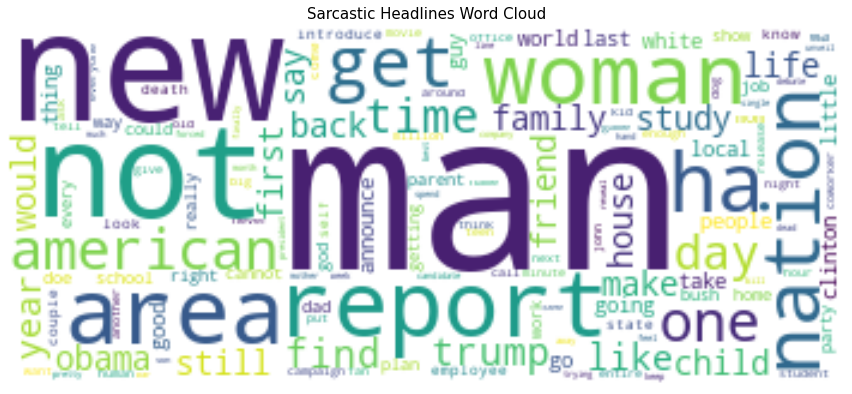

In [332]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
plot_wordcloud(sarcastic_headlines, title = 'Sarcastic Headlines Word Cloud')

Visualize Word Cloud for Non-Sarcastic Headlines

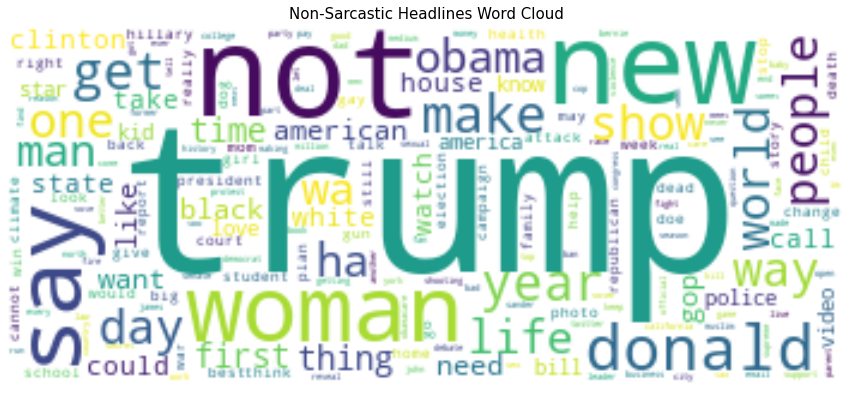

In [333]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
plot_wordcloud(non_sarcastic_headlines, title = 'Non-Sarcastic Headlines Word Cloud')

We will print the Five point summary for word count

In [334]:
display(data['nb_words'].describe().round(0).astype(int)); 

print('99% quantilie: {}'.format(data['nb_words'].quantile(0.99)));

count    26709
mean        10
std          3
min          2
25%          8
50%         10
75%         12
max         39
Name: nb_words, dtype: int64

99% quantilie: 18.0


Define model parameters

In [335]:
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 200

Tokenize the headlines and split the dataset into headlines and labels for training

In [336]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

In [337]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'# of Samples: {len(X)}')
print(f'# of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

# of Samples: 26709
# of Labels: 26709

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  327  686 2924 1254   54  291  107 1915    6 2014 3610]

Label of the first headline: 0


Determine the size of the vocabulary

In [338]:
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Vocabulary size is {vocab_size}')

Vocabulary size is 24962


Load and extract the GloVe embeddings file

In [339]:
glove_file = '/content/drive/MyDrive/Colab Notebooks/Assignments/Sequential NLP/glove.6B.zip'
with ZipFile(glove_file, 'r') as z:
  z.extractall()

Get the word emebddings using the provided Embeddings file

In [340]:
EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/Assignments/Sequential NLP/glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

Create the weight matrix using the GloVe embeddings

In [341]:
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

Split the dataset into training and test data sets

In [342]:
random_state=42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print("Traning Data set")
print(f'Number of rows: {x_train.shape[0]}')
print(f'Number of columns: {x_train.shape[1]}')
print(f'Number of unique words: {len(np.unique(np.hstack(x_train)))}')

print("\n\nTest Data set")
print(f'Number of rows: {x_test.shape[0]}')
print(f'Number of columns: {x_test.shape[1]}')
print(f'Number of unique words: {len(np.unique(np.hstack(x_test)))}')

Traning Data set
Number of rows: 21367
Number of columns: 39
Number of unique words: 9959


Test Data set
Number of rows: 5342
Number of columns: 39
Number of unique words: 7397


Build a fully connected NN with the following 

1. Embedding layer containing the input embedding vector that will be passed to the hidden layers

2. Convolution layers, Pooling and Dense Layers to learn the weights using forward and back prop

3. Bidirectional LSTM layer with 128 sequential units

4. Dropout layer that drop weights to prevent overfitting 

5. Output layer that uses a sigmoid function with binary cross entropy, since the output is binary (1 or 0 sentiment)

In [343]:
LSTM_Blocks = 128
dropout_ratio = 0.2
opt = 'adam'

In [344]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(LSTM_Blocks, return_sequences = True)))
model.add(GlobalMaxPool1D())

model.add(Dense(2048, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
# model.add(Dropout(dropout_ratio))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(dropout_ratio))

model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
#model.add(Dropout(dropout_ratio))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

#Callbacks
stop_early = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 10)  
save_best_model = ModelCheckpoint('best_sarcasm_detector_model.h5', monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
# logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [stop_early, save_best_model, reduce_lr]

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 39, 200)           2000200   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 39, 256)           336896    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 2048)              526336    
_________________________________________________________________
dense_45 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_46 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_47 (Dense)             (None, 256)              

Let us visualize the network architecture

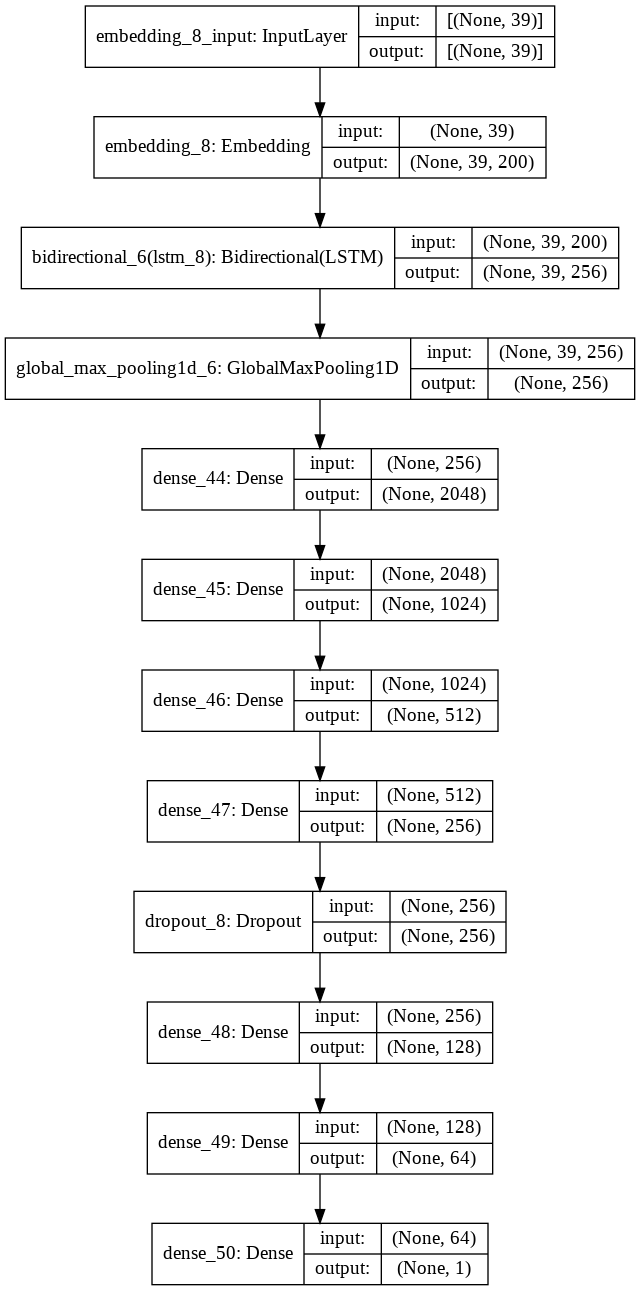

In [345]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

tf.keras.utils.plot_model(model, show_shapes = True)

Train the model for 15 epochs with a batch size of 100 and the callbacks defined above

In [346]:
batch_size = 100
epochs = 15

h = model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Epoch 1/15
171/171 - 5s - loss: 0.4841 - accuracy: 0.7511 - val_loss: 0.3599 - val_accuracy: 0.8383

Epoch 00001: val_accuracy improved from -inf to 0.83832, saving model to best_sarcasm_detector_model.h5
Epoch 2/15
171/171 - 2s - loss: 0.3156 - accuracy: 0.8650 - val_loss: 0.3322 - val_accuracy: 0.8505

Epoch 00002: val_accuracy improved from 0.83832 to 0.85049, saving model to best_sarcasm_detector_model.h5
Epoch 3/15
171/171 - 2s - loss: 0.2317 - accuracy: 0.9053 - val_loss: 0.3436 - val_accuracy: 0.8568

Epoch 00003: val_accuracy improved from 0.85049 to 0.85681, saving model to best_sarcasm_detector_model.h5
Epoch 4/15
171/171 - 2s - loss: 0.1615 - accuracy: 0.9372 - val_loss: 0.3869 - val_accuracy: 0.8489

Epoch 00004: val_accuracy did not improve from 0.85681
Epoch 5/15
171/171 - 2s - loss: 0.1165 - accuracy: 0.9569 - val_loss: 0.4533 - val_accuracy: 0.8512

Epoch 00005: val_accuracy did not improve from 0.85681
Epoch 6/15
171/171 - 2s - loss: 0.0836 - accuracy: 0.9687 - val_los

In [347]:
# %load_ext tensorboard
# %tensorboard --logdir log/

Let us plot the loss and accuracy of the model as the training progresses

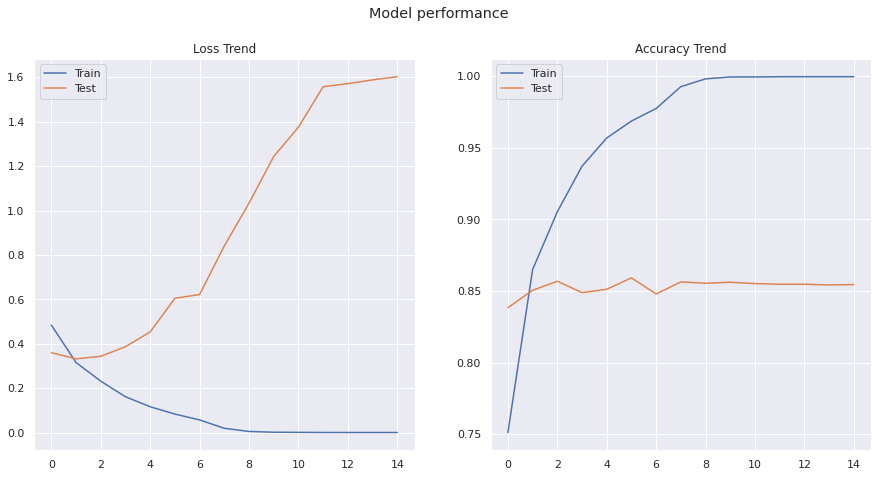

In [348]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

f, (laxis, acaxis) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Model performance')

laxis.plot(h.history['loss'], label = 'Train')
laxis.plot(h.history['val_loss'], label = 'Test')
laxis.set_title('Loss Trend')
laxis.legend(['Train', 'Test'])

acaxis.plot(h.history['accuracy'], label = 'Train')
acaxis.plot(h.history['val_accuracy'], label = 'Test')
acaxis.set_title('Accuracy Trend')
acaxis.legend(['Train', 'Test'])

plt.show()


Compute the test accuracy of the model

In [349]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 86.0


After experimenting different tuning of hyperparameters, the model accuracy is seen to have a threshold of around 87%. Various values for the following were experimented

* No. of LSTM Blocks
* No. of Hidden layers and neurons
* Optimizer algorithm (Adam, SGD, Adagrad)
* No. of Epochs
* Different batch sizes 

We will use the trained model to make predictions on the test data set and print the classification report

In [350]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      3116
           1       0.82      0.86      0.84      2226

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



Let us print the Confusion matrix for Sarcastic and Non Sarcastic headlines

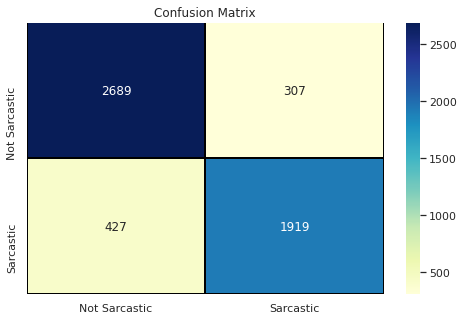

In [351]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'YlGnBu', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Not Sarcastic', 'Sarcastic'], 
            yticklabels = ['Not Sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

Utility function to return text of is_sarcastic label

In [352]:
def get_Sarcasm(label):
  if (label==0):
    text = 'Not Sarcastic'
  elif label==1:
    text='Sarcastic'
  return text

We will use the trained model to make predictions on a few randomly selected headlines from the data set

In [353]:
statements = ['don\'t nobody wanna hear area man run his mouth', #Sarcastic
              'readin\' researchin\' writin\' and the tools to make it happen', #Not Sarcastic
              'If you find me offensive. Then I suggest you quit finding me.', #Sarcastic
              'miles teller doing ok after bronco flips over in car crash', #Not Sarcastic
              'Amphibious pitcher makes debut', #Sarcastic
              'obamacare case to be turned against government on emissions rule', #Not Sarcastic
              'If I wanted to kill myself I would climb your ego and jump to your IQ.', #Sarcastic
              'mother of slain aurora teen calls out bernie sanders on gun control', #Not Sarcastic
              'I feel so miserable without you, it\'s almost like having you here.', #Sarcastic
              ]

for statement in statements:
  statement = statement.lower()
  statement = replace_words(statement)
  statement = remove_punctuation(statement)
  statement = lemmatize(statement)
  statement = re.sub(' +', ' ', statement)

  headline = tokenizer.texts_to_sequences(statement)
  headline = pad_sequences(headline, maxlen = maxlen, dtype = 'int32', value = 0)

  sentiment = (model.predict(headline) > 0.5).astype('int32')
  if(np.argmax(sentiment) == 0):
      print(f'{statement}\nPredicted: Not Sarcastic\n')
  elif (np.argmax(sentiment) == 1):
      print(f'{statement}\nPredicted: Sarcastic\n')

do not nobody wanna hear area man run his mouth
Predicted: Not Sarcastic

readin researchin writin and the tool to make it happen
Predicted: Not Sarcastic

if you find me offensive then i suggest you quit finding me
Predicted: Sarcastic

mile teller doing ok after bronco flip over in car crash
Predicted: Not Sarcastic

amphibious pitcher make debut
Predicted: Sarcastic

obamacare case to be turned against government on emission rule
Predicted: Not Sarcastic

if i wanted to kill myself i would climb your ego and jump to your iq
Predicted: Sarcastic

mother of slain aurora teen call out bernie sander on gun control
Predicted: Not Sarcastic



Conclusion 

* The data set was loaded and exploratory data analysis was perforned on it
* Preprocessing of data such as lower case conversion, special character correctpns, Lemmatization and superfluous space removal was performed
* After removing the features not required, the data set was split into training and test data sets
* Using the GloVe emebddings file provided, a weight matrix was created
* A Bidirectional LSTM Sequential model was compiled and used to train the data set
* Atfer several experiments on hyperparamters, the model was seen to provide an accuracy of ~87% without overfitting
* The trained model was used to predict the sarcastic indicator for a few random chosen entries from the data set  

In [354]:
# rands = random.sample(range(1, data.shape[0]), 10)
# statements, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

# i=1
# for statement, label in zip(statements,labels):
#   statement = statement.lower()
#   statement = replace_words(statement)
#   statement = remove_punctuation(statement)
#   statement = lemmatize(statement)
#   statement = re.sub(' +', ' ', statement)

#   headline = tokenizer.texts_to_sequences(statement)
#   headline = pad_sequences(headline, maxlen = maxlen, dtype = 'int32', value = 0)

#   predicted_sentiment = (model.predict(headline) > 0.8).astype('int32')
#   #print(predicted_sentiment)
#   print(f'{i}. {statement} \nActual: {get_Sarcasm(label)} Predicted: {get_Sarcasm(np.argmax(predicted_sentiment))}\n')

#   i=i+1